<p>

## Background

The data set used contains 5 years of daily sales volume for a sample store.  We are interested in identifying the patterns from the sales data and what we could communicate to managers of the store.

We are also interested in developing a model to predict next years sales volume.

### EDA

In [1]:
#Importing basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Reading data
df = pd.read_csv('datasets/sample_dines_data.csv', index_col='date', parse_dates=True)

##### Quick Cleaning

In [3]:
df.head()

,Unnamed: 0,sales
date,,
2014-01-01 05:49:12,0,1742
2014-01-02 05:49:12,1,1808
2014-01-03 05:49:12,2,1887
2014-01-04 05:49:12,3,1983
2014-01-05 05:49:12,4,2087


In [4]:
#Remove Unnamed:0 column, basically an index
df = df.drop(columns='Unnamed: 0')

In [5]:
df.isnull().sum()

sales    0
dtype: int64

##### Looking for patterns

In [6]:
# Import seasonal decompose
from statsmodels.tsa.seasonal import seasonal_decompose

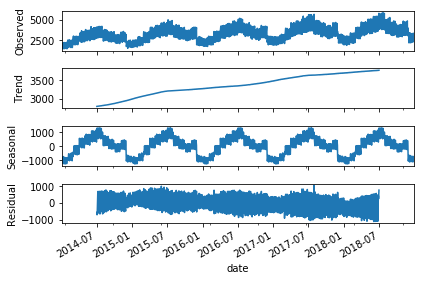

In [7]:
# Perform additive decomposition
decomp = seasonal_decompose(df, 
                            freq=365)
decomp.plot()
plt.show()

Here we see from the top plot (**observed**) that there is seasonality, trending upward, with the following pattern: sales peak during the summers and trough during the winters.  Furthermore, the second plot (**trend**) shows that the sales are increasing per year, while the third plot (**seasonal**) tells us that this is an additive seasonality since the range is standard throughout the years.

#### Word to managing team

To the new managers, I would recommend you to increase staff during the summmer season as sales increase, possible due to tourism.  I would also tell them to prepare for a decrease in sales during the winter season.  Lastly, I would advise to look at the big picture as the sales are trending upward during the five years.

### Forecasting

##### Couple more changes to the data

Because we want to have the same number of data points per 'season,' i.e. 365 days in a year, we need to remove the extra day from the leap year 2016.

In [8]:
df[df.index=='2016-02-29 05:49:12'] = np.nan
df = df.dropna()

Change the index to a DatetimeIndex

In [9]:
df.index = pd.DatetimeIndex(df.index).to_period('D')

##### Choosing a Model

Because this has seasonality and stationarity as seen from the last plots above, I decided to opt for a SARIMA model.  To determine which orders the SARIMA model should take, I looked at the autocorrelation and partial autocorrelation plots.  From the plots above, we need to detrend it, since it's not stationary.  We choose a rolling mean of 15

In [10]:
df_diff = df.diff().diff(15).dropna()

In [11]:
#Import plotting packages
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

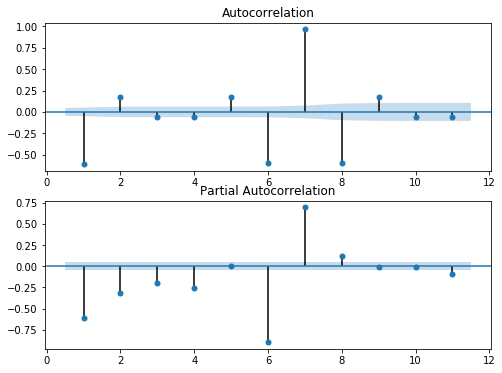

In [12]:
#Plot regular ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

plot_acf(df_diff, lags=11, zero=False,ax=ax1)
plot_pacf(df_diff, lags=11,zero=False, ax=ax2)

plt.show()

From above there's no particular trend for the ACF nor the PACF, so we choose the non-seasonal orders to be p = 0 and q = 0.

/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


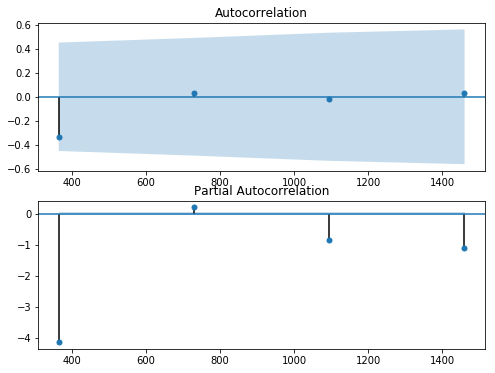

In [13]:
#Plotting the Seasonal ACF and PACF
# Make list of lags
lags = [365, 730, 1095, 1460]

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,6))

plot_acf(df_diff,lags=lags,zero=False, ax=ax1)
plot_pacf(df_diff, lags=lags, zero=False, ax=ax2)

plt.show()

From the above plots we see that both the ACF and PACF tail down, so we choose the seasonal orders to be P = 1 and Q = 1.

Lastly to determine the differencing order, we look at the Augmented Dicky-Fuller plot

In [14]:
#import necessary package
from statsmodels.tsa.stattools import adfuller

In [15]:
result = adfuller(df['sales'])
print(result[0])

-3.0113944543422373


In [16]:
df_diff = df.diff().dropna()
result_diff = adfuller(df_diff['sales'])
print(result_diff[0])

-8.83532654420027


In [17]:
df_diff2 = df_diff.diff().dropna()
result_diff2 = adfuller(df_diff2['sales'])
print(result_diff2[0])

-15.761426076304158


From the ADF statistic, we choose the differencing order to be 1.  While the ADF statistic is lesser for d = 2, we don't want to overfit.

##### Training SARIMA$(0,1,0)(1,1,1)_{365}$

In [ ]:
# Import model class
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
#Split data set to 3 and 2 years, i.e. 60% train
train_df = df[df.index.year <= 2016].copy()
test_df = df[df.index.year > 2016].copy()

In [ ]:
#Training and fitting the model
model = SARIMAX(train_df, order=(0,1,0), seasonal_order=(1,1,1,365), trend='c')
start_params = np.r_[[0] * (model.k_params - 1), 1]
results = model.fit(start_params=start_params)

I have attached a results.png file for the summary of the model fitting.  The AIC is high, but in consideration of time, I was not able to consider other SARIMA models, as each model takes ~2 hours to fit in my computer.  Furthermore, the model has a Prob(Q) and Prob(JB) of 0, which means that the residuals are correlated and are not normally distributed, which means that the model that I have trained isn't good, just from those values.

If I had more time or a faster computer, I would have use pmdarima's auto_arima to find the best fit model, or learned enough R to implement time series analysis through RStudio.

##### How's the predictive power of this model?

I have read in the csv files of the predictions for the test set

In [12]:
df_pred = pd.read_csv('datasets/salesprediction.csv', index_col='date', parse_dates=True)

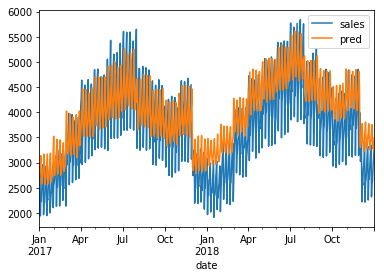

In [13]:
df_pred.plot()

Just from looking at the plot, this not-so-good model **over-estimates** the sales.  We can quantify the discrepancy with **root mean squared error**.

In [14]:
#Import sklearn package
from sklearn.metrics import mean_squared_error

In [15]:
rmse = np.sqrt(mean_squared_error(df_pred['sales'], df_pred['pred']))
print(rmse)

724.7486478392863


As discussed above, the model can be improved, and this can be seen with the high RMSE score of ~724.

##### Visualizing the whole thing

In [47]:
#Read in the predictions for 2019
df_pred_2019 = pd.read_csv('datasets/salesforecast_louispenafiel.csv')

#Read in non-altered original dataset
df = pd.read_csv('datasets/sample_dines_data.csv', index_col='date', parse_dates=True)

In [48]:
start_date = pd.to_datetime('2014-01-01')
end_date = pd.to_datetime('2019-12-31')
dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [61]:
#Use bools to make this easier for me
actual_bool = dates<'2019'
pred_bool = (dates>='2017') & (dates<'2019')
forecast_bool = dates>='2019'

Text(0,0.5,'Sales per Day')

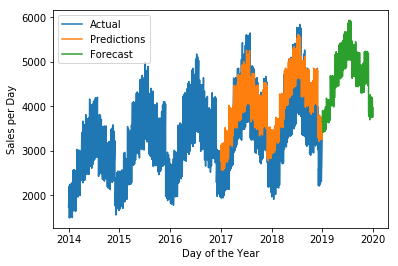

In [64]:
plt.plot(dates[actual_bool], df['sales'], label='Actual')
plt.plot(dates[pred_bool], df_pred['pred'], label='Predictions')
plt.plot(dates[forecast_bool], df_pred_2019['pred'], label='Forecast')
plt.legend()
plt.xlabel('Day of the Year')
plt.ylabel('Sales per Day')

<p>

<p>